In [38]:
import numpy as np
import pandas as pd
import time
import sys
import os
import argparse
import shutil
import pickle
import itertools

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, WeightedRandomSampler, SequentialSampler

from bert_dataloader import get_wiki_data, get_fake_data
from bert_models import BertMultiHeadModel # Custom model 

from transformers import BertForSequenceClassification, BertTokenizer, AdamW, get_linear_schedule_with_warmup, PretrainedConfig

In [39]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; error rate={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [22]:
def print_reg_scores(preds, truth, multi_label=False):
    if multi_label:
        print("fake news accuracy: {:5f}".format(np.mean(preds == truth)))
        num_labels = 4
    else:
        print("wiki accuracy: {:5f}".format(np.mean(preds == truth)))
        num_labels = 2
    pred_prop = np.array([np.sum(preds==i) for i in range(num_labels)]) # 4 labels
    pred_prop = pred_prop / np.sum(pred_prop)
    truth_prop = np.array([np.sum(truth==i) for i in range(num_labels)]) # 4 labels
    truth_prop = truth_prop / np.sum(truth_prop)
    print("per class pred vs truth proportion: ", pred_prop, truth_prop)

def print_f1_scores(preds, truth, multi_label=False):
    labels = ['unrelated', 'agree', 'disagree', 'discuss'] if multi_label else ['not attack', 'attack']
    for i, label in enumerate(labels): # 4 classes
        print("label '{}':".format(label))
        precision = np.mean(preds[preds==i] == truth[preds==i])
        recall = np.mean(preds[truth==i] == truth[truth==i])
        f1_score = 2 * precision * recall / (precision + recall)
        print("f1 score: {:5f}, precision: {:5}, recall: {:5f}".format(f1_score, precision, recall))

In [4]:
ls ..

README.md            multi-epoch-2/       wiki-epoch-10/
data/                multi-epoch-6/       wiki-epoch-5/
fake-epoch-10/       multi_fake_pickle.p  wiki_pickle.p
fake_pickle.p        src/


# single-head model on fake news data, 10 epochs

In [23]:
with open("../fake_pickle.p", "rb") as file:
    d = pickle.load(file)
fake_preds, fake_truth = d['preds'], d['truth']

In [24]:
m = confusion_matrix(fake_truth, fake_preds)
m 

array([[7034,   60,   15,  189],
       [   9,  515,  120,  106],
       [   3,   32,  121,    8],
       [  21,  223,  134, 1404]])

In [25]:
np.sum((preds==1) * (truth==0))

60

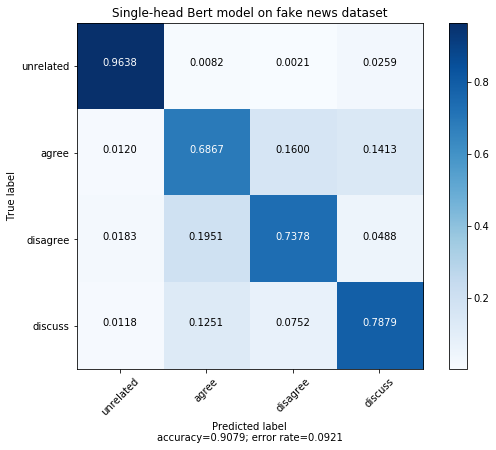

In [26]:
s = "Single-head Bert model on fake news dataset"
plot_confusion_matrix(m, ['unrelated', 'agree', 'disagree', 'discuss'], title=s, normalize=True)

In [27]:
print_reg_scores(fake_preds, fake_truth, multi_label=True)
print_f1_scores(fake_preds, fake_truth, multi_label=True)

fake news accuracy: 0.907945
per class pred vs truth proportion:  [0.70712427 0.08304983 0.03902341 0.17080248] [0.73023814 0.07504503 0.01640985 0.17830698]
label 'unrelated':
f1 score: 0.979325, precision: 0.9953304089429744, recall: 0.963826
label 'agree':
f1 score: 0.651899, precision: 0.6204819277108434, recall: 0.686667
label 'disagree':
f1 score: 0.436823, precision: 0.31025641025641026, recall: 0.737805
label 'discuss':
f1 score: 0.804815, precision: 0.8224956063268892, recall: 0.787879


In [56]:
np.mean([0.979325, 0.651899, 0.436823, 0.804815])

0.7182155

# single-head model on wiki data, 10 epochs

In [28]:
with open("../wiki_pickle.p", "rb") as file:
    d = pickle.load(file)
wiki_preds, wiki_truth = d['preds'], d['truth']

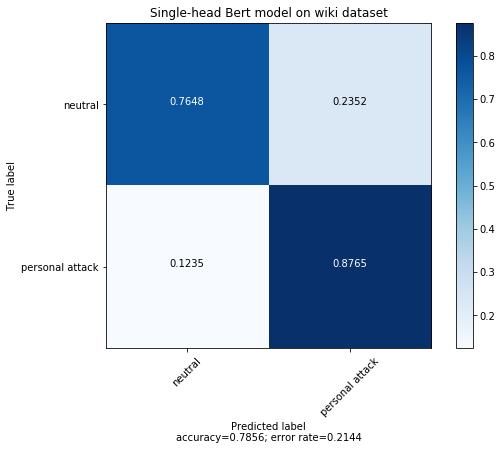

In [29]:
m = confusion_matrix(wiki_truth, wiki_preds)
s = "Single-head Bert model on wiki dataset"
plot_confusion_matrix(m, ['neutral', 'personal attack'], title=s, normalize=True)

In [30]:
print_reg_scores(wiki_preds, wiki_truth, multi_label=False)
print_f1_scores(wiki_preds, wiki_truth, multi_label=False)

wiki accuracy: 0.785573
per class pred vs truth proportion:  [0.64565536 0.35434464] [0.81417724 0.18582276]
label 'not attack':
f1 score: 0.853115, precision: 0.9644503842298697, recall: 0.764824
label 'attack':
f1 score: 0.603035, precision: 0.4596371605990503, recall: 0.876480


# multi-head model on fake news data, 6 epochs

In [12]:
with open("../multi_fake_pickle_6.p", "rb") as file:
    d = pickle.load(file)
multi_fake_preds, multi_fake_truth = d['preds'], d['truth']

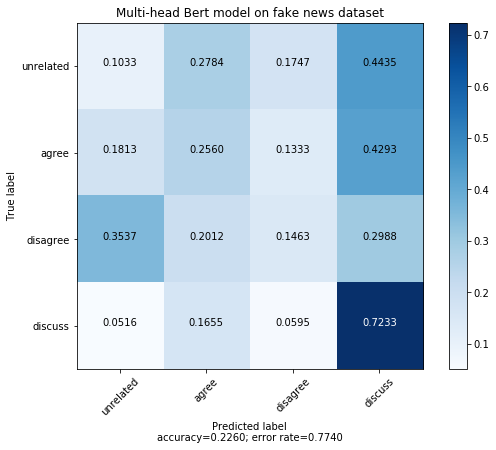

In [13]:
m = confusion_matrix(multi_fake_truth, multi_fake_preds)
s = "Multi-head Bert model on fake news dataset"
plot_confusion_matrix(m, ['unrelated', 'agree', 'disagree', 'discuss'], title=s, normalize=True)

# multi-head model on wiki data, 6 epochs

In [31]:
with open("../multi_wiki_pickle_6.p", "rb") as file:
    d = pickle.load(file)
multi_wiki_preds, multi_wiki_truth = d['preds'], d['truth']

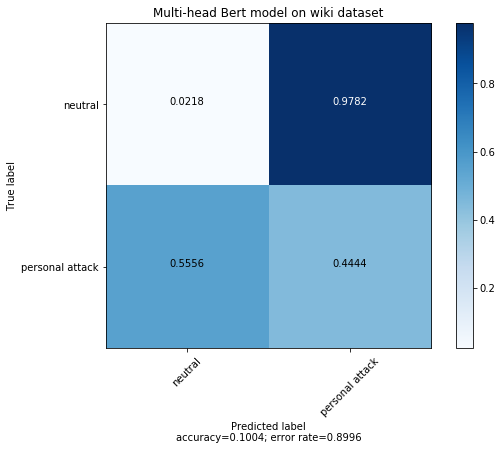

In [32]:
m = confusion_matrix(multi_wiki_truth, multi_wiki_preds)
s = "Multi-head Bert model on wiki dataset"
plot_confusion_matrix(m, ['neutral', 'personal attack'], title=s, normalize=True)

In [33]:
print_reg_scores(multi_wiki_preds, multi_wiki_truth, multi_label=False)
print_f1_scores(multi_wiki_preds, multi_wiki_truth, multi_label=False)

wiki accuracy: 0.100354
per class pred vs truth proportion:  [0.12101993 0.87898007] [0.81417724 0.18582276]
label 'not attack':
f1 score: 0.038014, precision: 0.14688057040998218, recall: 0.021832
label 'attack':
f1 score: 0.155105, precision: 0.09394787218377264, recall: 0.444393


# multi-head model on fake news data, 11 epochs

In [61]:
with open("../multi_fake_pickle_11.p", "rb") as file:
    d = pickle.load(file)
multi_fake_preds, multi_fake_truth = d['preds'], d['truth']

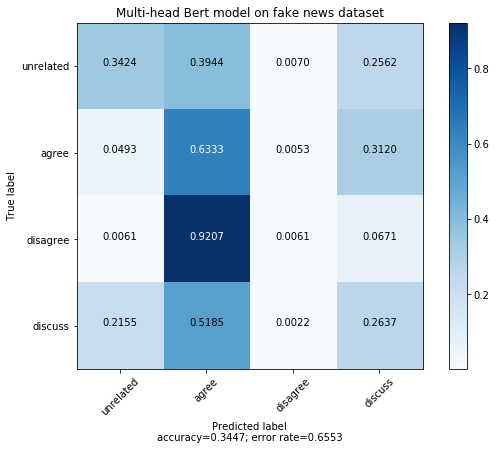

In [62]:
m = confusion_matrix(multi_fake_truth, multi_fake_preds)
s = "Multi-head Bert model on fake news dataset"
plot_confusion_matrix(m, ['unrelated', 'agree', 'disagree', 'discuss'], title=s, normalize=True)

In [63]:
print_reg_scores(multi_fake_preds, multi_fake_truth, multi_label=True)
print_f1_scores(multi_fake_preds, multi_fake_truth, multi_label=True)

fake news accuracy: 0.344707
per class pred vs truth proportion:  [0.29227537 0.44306584 0.0060036  0.25865519] [0.73023814 0.07504503 0.01640985 0.17830698]
label 'unrelated':
f1 score: 0.489089, precision: 0.8555289284491613, recall: 0.342423
label 'agree':
f1 score: 0.183469, precision: 0.10727190605239385, recall: 0.633333
label 'disagree':
f1 score: 0.008929, precision: 0.016666666666666666, recall: 0.006098
label 'discuss':
f1 score: 0.215251, precision: 0.18181818181818182, recall: 0.263749


In [64]:
np.mean([0.489089, 0.183469, 0.008929, 0.215251])

0.22418449999999998

# multi-head model on wiki data, 11 epochs

In [58]:
with open("../multi_wiki_pickle_11.p", "rb") as file:
    d = pickle.load(file)
multi_wiki_preds, multi_wiki_truth = d['preds'], d['truth']

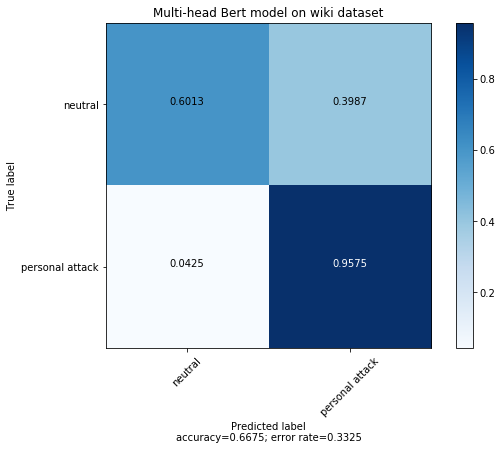

In [59]:
m = confusion_matrix(multi_wiki_truth, multi_wiki_preds)
s = "Multi-head Bert model on wiki dataset"
plot_confusion_matrix(m, ['neutral', 'personal attack'], title=s, normalize=True)

In [60]:
print_reg_scores(multi_wiki_preds, multi_wiki_truth, multi_label=False)
print_f1_scores(multi_wiki_preds, multi_wiki_truth, multi_label=False)

wiki accuracy: 0.667530
per class pred vs truth proportion:  [0.49749763 0.50250237] [0.81417724 0.18582276]
label 'not attack':
f1 score: 0.746530, precision: 0.9841297372300755, recall: 0.601346
label 'attack':
f1 score: 0.516986, precision: 0.3540825963767494, recall: 0.957511


# multi-head model on fake news data, 21 epochs

In [50]:
with open("../multi_fake_pickle_21.p", "rb") as file:
    d = pickle.load(file)
multi_fake_preds, multi_fake_truth = d['preds'], d['truth']

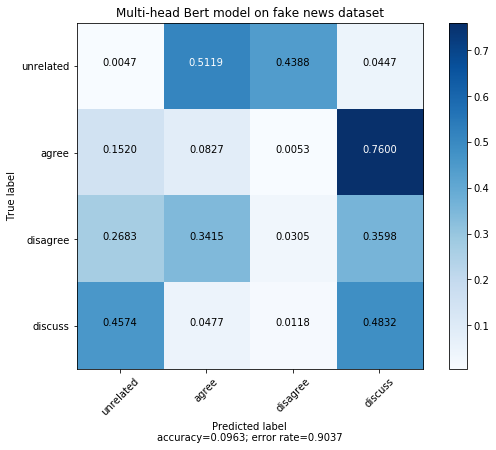

In [51]:
m = confusion_matrix(multi_fake_truth, multi_fake_preds)
s = "Multi-head Bert model on fake news dataset"
plot_confusion_matrix(m, ['unrelated', 'agree', 'disagree', 'discuss'], title=s, normalize=True)

In [52]:
print_reg_scores(multi_fake_preds, multi_fake_truth, multi_label=True)
print_f1_scores(multi_fake_preds, multi_fake_truth, multi_label=True)

fake news accuracy: 0.096258
per class pred vs truth proportion:  [0.10076046 0.39413648 0.32339404 0.18170903] [0.73023814 0.07504503 0.01640985 0.17830698]
label 'unrelated':
f1 score: 0.008188, precision: 0.033763654419066536, recall: 0.004659
label 'agree':
f1 score: 0.026445, precision: 0.01574003554201574, recall: 0.082667
label 'disagree':
f1 score: 0.002945, precision: 0.001547029702970297, recall: 0.030488
label 'discuss':
f1 score: 0.478599, precision: 0.4741189427312775, recall: 0.483165


In [57]:
np.mean([0.008188, 0.026445, 0.002945, 0.478599])

0.12904425

# multi-head model on wiki data, 21 epochs

In [53]:
with open("../multi_wiki_pickle_21.p", "rb") as file:
    d = pickle.load(file)
multi_wiki_preds, multi_wiki_truth = d['preds'], d['truth']

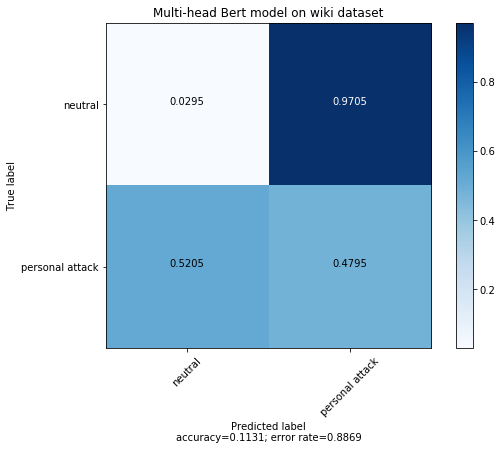

In [54]:
m = confusion_matrix(multi_wiki_truth, multi_wiki_preds)
s = "Multi-head Bert model on wiki dataset"
plot_confusion_matrix(m, ['neutral', 'personal attack'], title=s, normalize=True)

In [55]:
print_reg_scores(multi_wiki_preds, multi_wiki_truth, multi_label=False)
print_f1_scores(multi_wiki_preds, multi_wiki_truth, multi_label=False)

wiki accuracy: 0.113125
per class pred vs truth proportion:  [0.12076107 0.87923893] [0.81417724 0.18582276]
label 'not attack':
f1 score: 0.051407, precision: 0.19899964272954626, recall: 0.029516
label 'attack':
f1 score: 0.167301, precision: 0.1013298002846067, recall: 0.479452
